# LSTM test

follows https://www.tensorflow.org/tutorials/structured_data/time_series notebook on time series forecasting using neural network models in Tensorflow.

In [1]:
import pickle
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import os
import datetime
import time
import IPython

startTime = time.time()

In [2]:
def trainTestSplit(files):
    """
    
    Perform a training test split

    Args:
        files (list): list of the files in the full dataset
    
    Returns:
        training/validation/test (list): list of files in each set

    """
    validation = ['argH']
    files = np.delete(files,0)
    training = files[:2]
    test = files[2:]
    validation = test
    print("training set:",training,"\n",
    "validation set:",validation,"\n",
    "test set:",test)
    return training, validation, test

extract function creates a new dataframe with only the required features and with cell mass and time 'exploded' from their nested lists.

In [3]:
def extract(file):
    # bigFramaList = []
    # for file in files:
    with open(file,'rb') as f:
        data = pickle.load(f)
    df = data.dropna(axis=1, how='all')
    df['generation'] = df['generation'].apply(lambda x: int(x.split('_')[-1]))
    sorted_df = df.sort_values(by=['gene_ko','generation'],kind='mergesort')
    koData = sorted_df[['generation','gene_ko','cellMass', 'time']]
    koDataExp = koData.explode('cellMass')
    koDatat = koData.explode('time')
    koDataExp['time'] = koDatat['time']
    koDataExp['gene_koF'] = pd.factorize(koDataExp['gene_ko'])[0]
    # bigFramaList.append(koDataExp)
    # bigFrama = pd.concat(bigFramaList, ignore_index=True)
    return koDataExp

koDataExp = extract("toy_data.pkl")

C:\Users\gavla\AppData\Local\Temp\ipykernel_28808\1558248490.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['generation'] = df['generation'].apply(lambda x: int(x.split('_')[-1]))


here 'files' makes a list of unique gene knockouts to make a train test split, in the full version this would be a list of the pickle files (full dataset is composed of 20 .pkl files)

In [8]:
files = koDataExp['gene_ko'].unique()
# koFiles = [f for f in files if len(f)<=12]
# wFiles = [f for f in files if len(f)>=12]

training, validation, test = trainTestSplit(files)

train_df = koDataExp[koDataExp['gene_ko'].isin(training)]
val_df = koDataExp[koDataExp['gene_ko'].isin(validation)]
test_df = koDataExp[koDataExp['gene_ko'].isin(test)]

dfs = [train_df, val_df, test_df]

for df in dfs:
    df.drop(columns='gene_ko',inplace=True)

training set: ['glmU' 'murB'] 
 validation set: ['murI' 'yidC'] 
 test set: ['murI' 'yidC']


C:\Users\gavla\AppData\Local\Temp\ipykernel_42808\1050986337.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns='gene_ko',inplace=True)
C:\Users\gavla\AppData\Local\Temp\ipykernel_42808\1050986337.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns='gene_ko',inplace=True)
C:\Users\gavla\AppData\Local\Temp\ipykernel_42808\1050986337.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns='

In [9]:
train_mean = train_df.mean()
train_std = train_df.std()
print(train_mean, train_std)

generation       2.631498
cellMass      1503.405858
time          9710.099388
gene_koF         1.498471
dtype: object generation       1.628701
cellMass       324.647412
time          5624.752911
gene_koF          0.50038
dtype: object


In [11]:

# for df in dfs:
#     df = (df - train_mean)/train_std

train_df = (train_df - train_mean)/train_std
normTrnMean = train_df.mean()
print(normTrnMean)

column_indices = {name: i for i, name in enumerate(train_df.columns)}
num_features = train_df.shape[1]

# print(train_df.head())

generation    0.0
cellMass     -0.0
time         -0.0
gene_koF      0.0
dtype: object


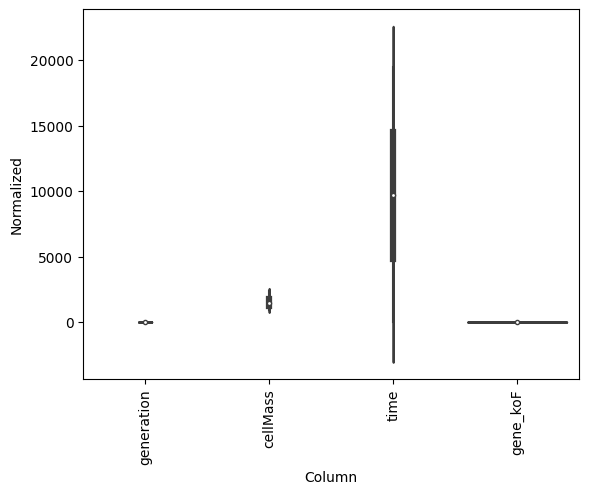

In [35]:
df_std['Normalized'] = pd.to_numeric(df_std['Normalized'])
plt.figure()
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(train_df.keys(), rotation=90)

this class is more or less directly from the Tensorflow notebook, overall idea is to make evenly spaced windows of time series data to learn and predict.

In [39]:
class WindowGenerator():
    def __init__(self, input_width ,label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
        #store raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        #work out the label column indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        #work out the window params
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0,input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}'
            f'\n Input indices: {self.input_indices}'
            f'\n Label indices: {self.label_indices}'
            f'\n Label Column name(s): {self.label_columns}'
        ])
    
def split_window(self,features):
    inputs = features[:, self.input_slice,:]
    labels = features[:, self.labels_slice,:]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.label_columns_indices[name]] for name in self.label_columns],
            axis=-1
        )
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

def plot(self, model=None, plot_col='cellMass /fg', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
            label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                marker='X', edgecolors='k', label='Predictions',
                c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time /s')
    plt.savefig('lstm_example')

WindowGenerator.plot = plot
    
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=False,
        batch_size=32
    )

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
    return self.make_dataset(self.train_df)
@property
def val(self):
    return self.make_dataset(self.val_df)
@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """
    Get and cache an example batch of 'inputs, labels` for plotting.
    """
    result=getattr(self, '_example', None)
    if result is None:
        #No example batch was found, so get one from the train dataset
        result = next(iter(self.train))
        #and cache for next time
        self._example = result

    return result


WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example


In [50]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def plot(self, model=None, plot_col='cellMass', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
            label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time \s')

WindowGenerator.plot = plot

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

followed through some of the other network examples, here is a convolutional NN

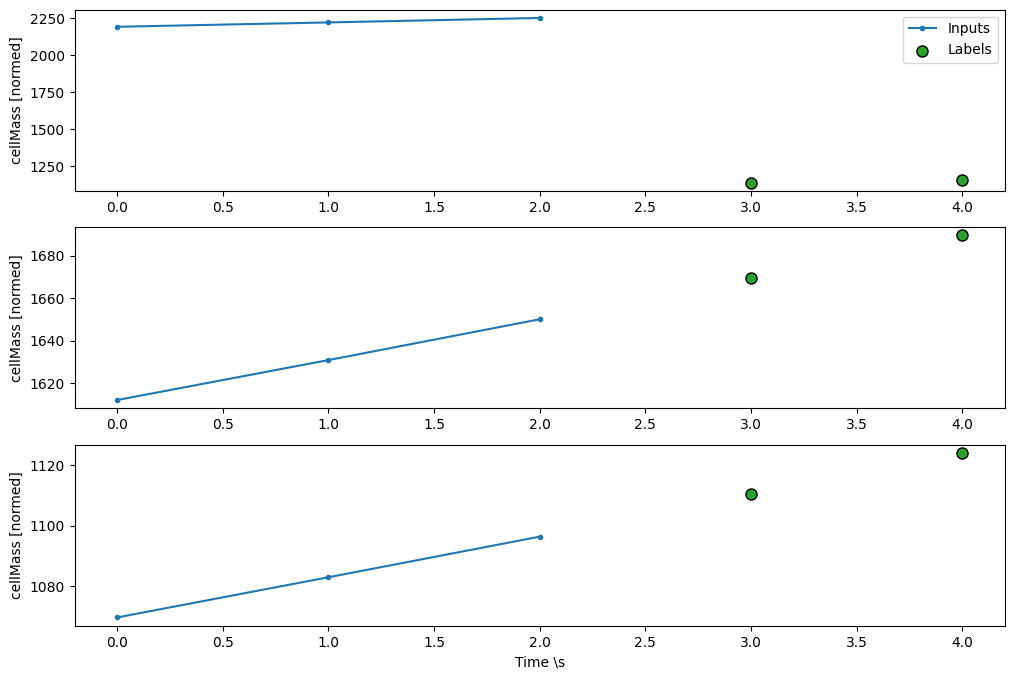

In [51]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=2,
    shift=2,
    label_columns=['cellMass']
)

conv_window.plot()

generating the window for the multi step lstm model and create model with specified layers.

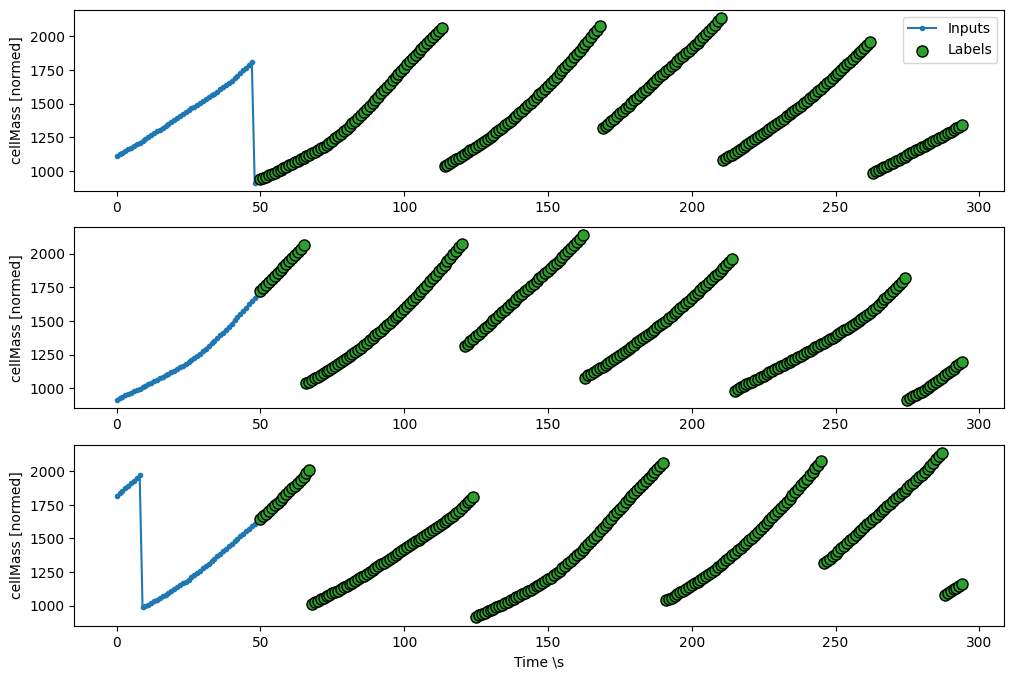

In [72]:
MAX_EPOCHS = 10
OUT_STEPS = 245
multi_window = WindowGenerator(input_width=50,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=['cellMass'])

multi_window.plot()
multi_window

multi_lstm_model = tf.keras.Sequential([
    #shape [batch, time, features] => [batch, lstm_units]
    #adding more lstm units just overfits more quickly
    tf.keras.layers.LSTM(32, return_sequences=False),
    #shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

compile model with conditions for early termination, and performance metrics. As can be viewed in the below figure, the performance at this stage was not good. If I can find a way to access the full code I will follow up with this

10/10 [==============================] - 0s 8ms/step - loss: 2366425.2500 - mean_absolute_error: 1506.8862


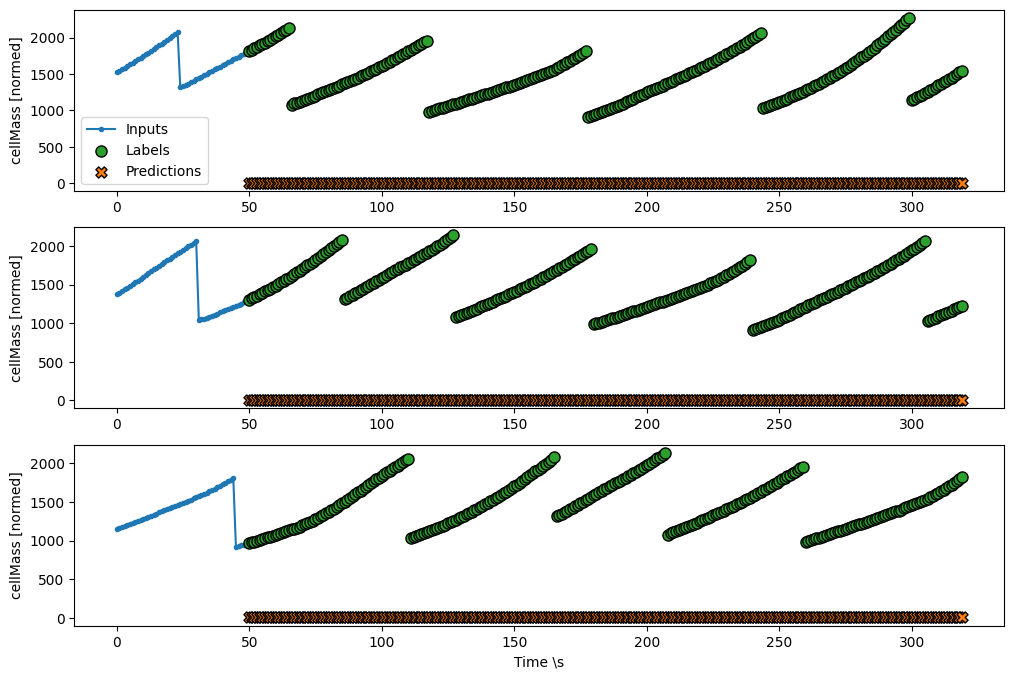

In [57]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')

multi_lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
history = multi_lstm_model.fit(multi_window.train, epochs=20,
                    validation_data=multi_window.val,
                    callbacks=[early_stopping])

IPython.display.clear_output()

multi_val_performance = {}
multi_performance = {}

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val, return_dict=True)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_lstm_model)

In [59]:
for name, value in multi_performance.items():
    print(f'{name:15s}: {value[metric_name]:0.4f}')

endTime = time.time()

runTime = endTime - start_time

print(f'Runtime of script: {runTime}')

NameError: name 'metric_name' is not defined